## Experiment 7 — Implementing K-Means Clustering from Scratch

### Objective

The objective of this experiment is to implement the K-Means clustering algorithm from scratch using NumPy, apply it to a customer segmentation dataset, visualize the results, interpret the clusters, and compare the implementation with scikit-learn's version.


### 1. Introduction

K-Means is an unsupervised learning algorithm used for clustering similar data points into groups. The algorithm aims to minimize the within-cluster sum of squares (inertia) by iteratively updating centroids.


### 2. Importing Libraries and Dataset


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKKMeans

## Dataset and Preprocessing

### 3. Data Exploration and Preprocessing
We import dataset then perform eda , check for missing values, and normalize the data.

In [6]:
df = pd.read_csv("/Users/yug/coding stuff/ml or dl /ml lab /exp 7/Mall_Customers - Mall_Customers.csv")
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [7]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [8]:
print("Shape of dataset:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nFirst 5 rows:\n", df.head())
print("\nSummary statistics:\n", df.describe())

Shape of dataset: (200, 5)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

First 5 rows:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                   

In [9]:
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())


Missing Values per Column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Duplicate Rows: 0


/var/folders/2j/6bvnywcd4k76ggrbfxbv4ckc0000gn/T/ipykernel_69462/1320828892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Gender", data=df, palette="pastel")


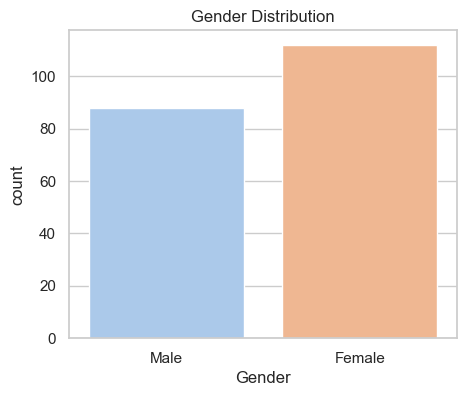

In [10]:
plt.figure(figsize=(5,4))
sns.countplot(x="Gender", data=df, palette="pastel")
plt.title("Gender Distribution")
plt.show()

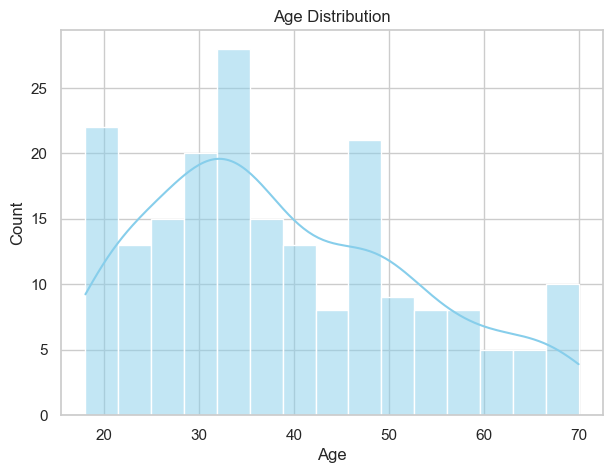

In [11]:
plt.figure(figsize=(7,5))
sns.histplot(df["Age"], bins=15, kde=True, color="skyblue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()

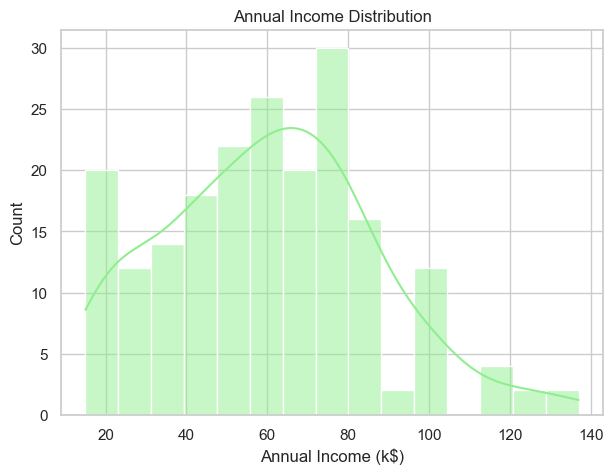

In [12]:
plt.figure(figsize=(7,5))
sns.histplot(df["Annual Income (k$)"], bins=15, kde=True, color="lightgreen")
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.show()

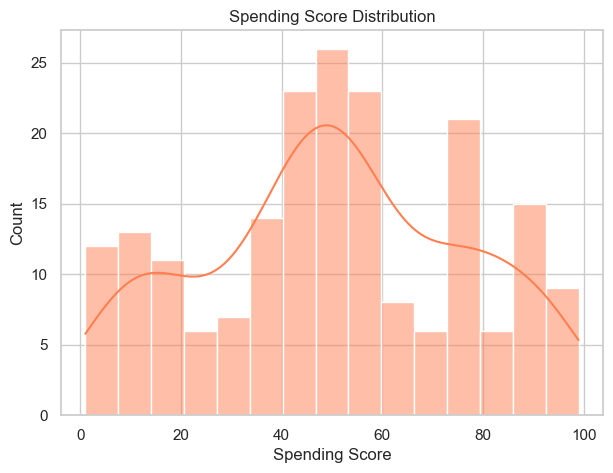

In [13]:
plt.figure(figsize=(7,5))
sns.histplot(df["Spending Score (1-100)"], bins=15, kde=True, color="coral")
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score")
plt.show()

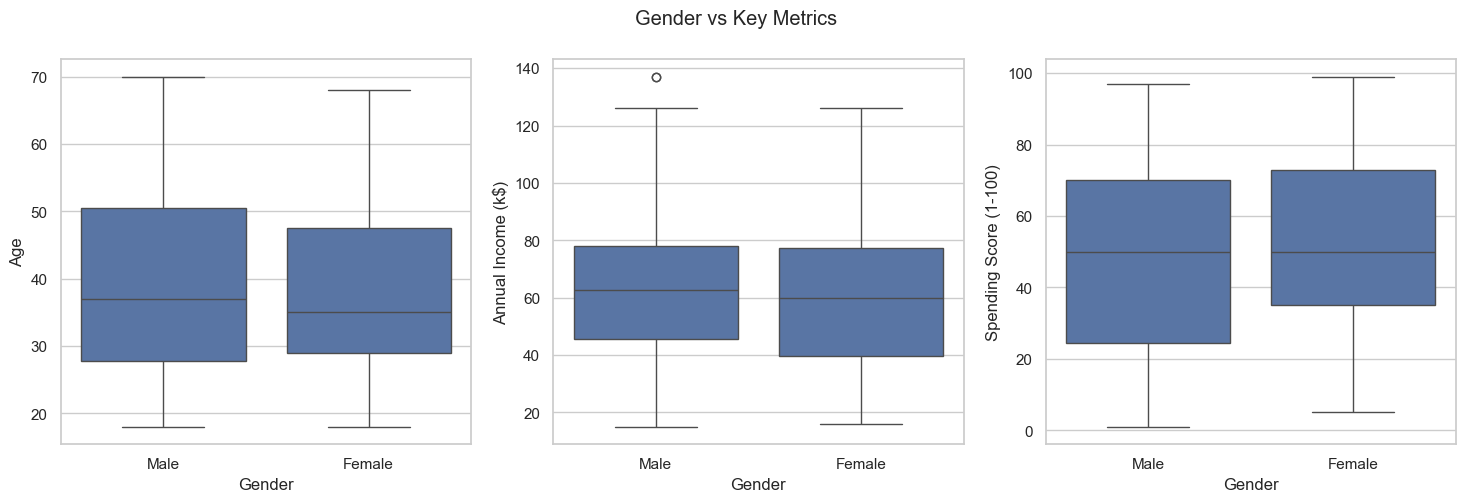

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(x="Gender", y="Age", data=df, ax=axes[0])
sns.boxplot(x="Gender", y="Annual Income (k$)", data=df, ax=axes[1])
sns.boxplot(x="Gender", y="Spending Score (1-100)", data=df, ax=axes[2])
plt.suptitle("Gender vs Key Metrics")
plt.show()

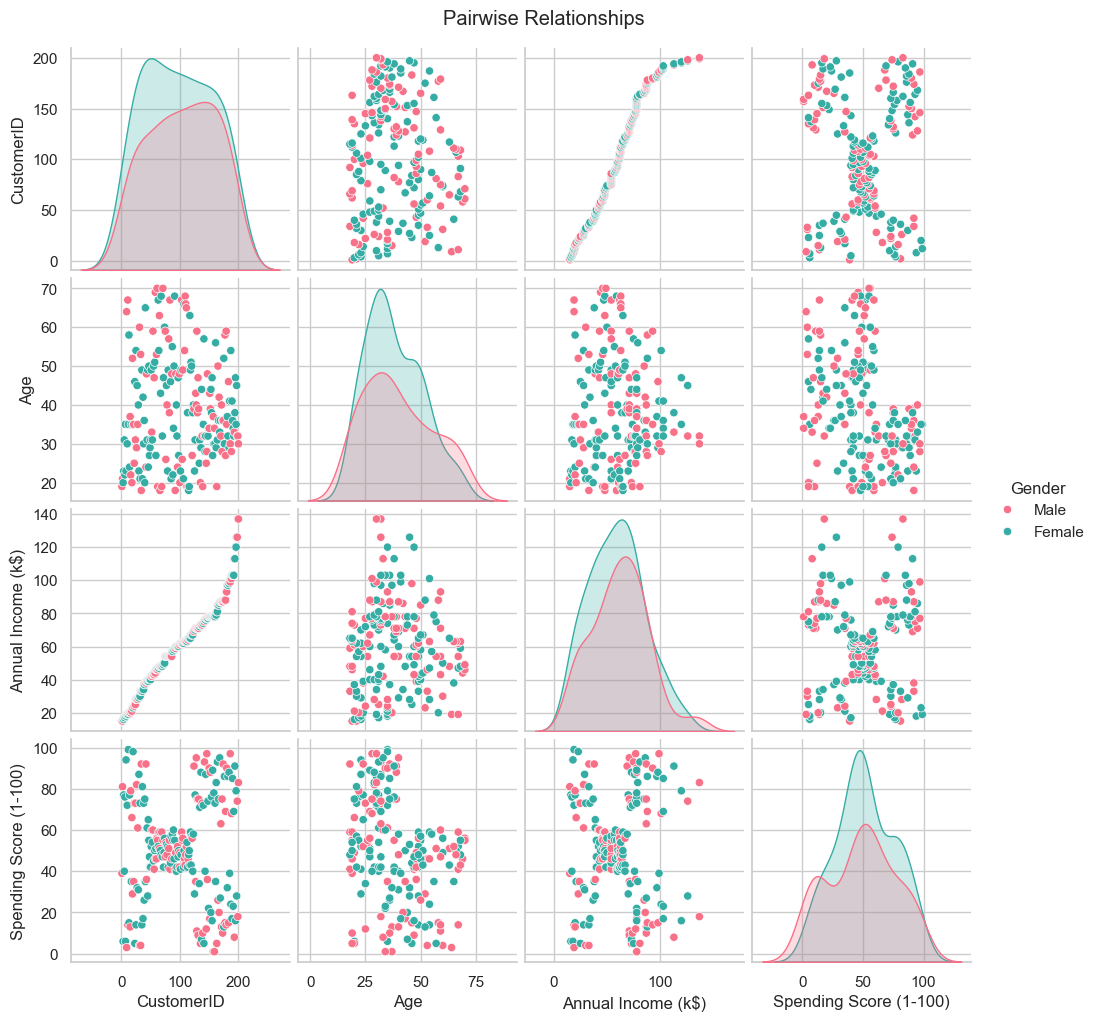

In [15]:
sns.pairplot(df, hue="Gender", palette="husl")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

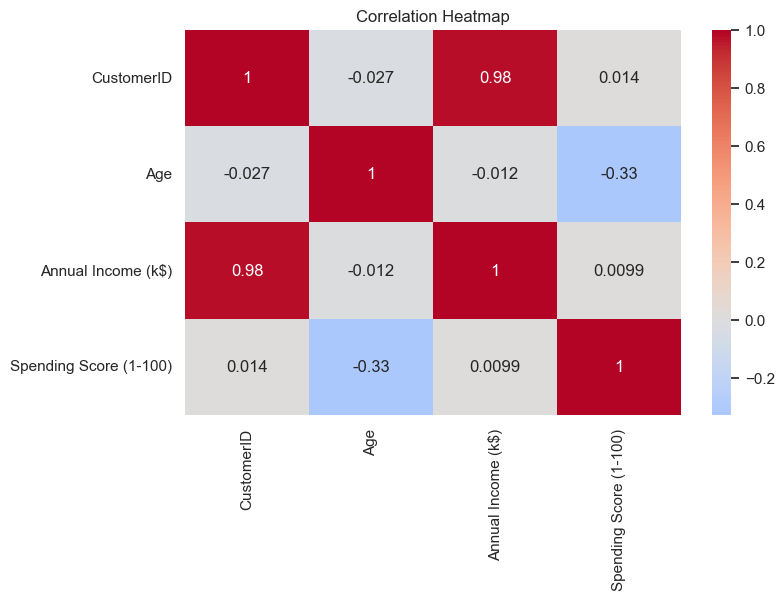

In [16]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

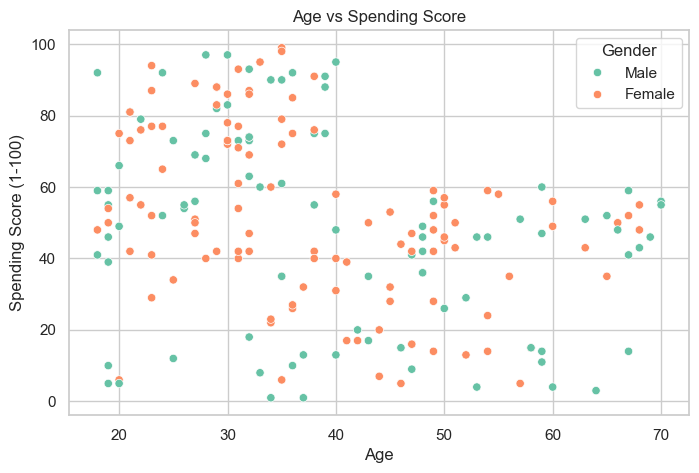

In [17]:
sns.scatterplot(x="Age", y="Spending Score (1-100)", hue="Gender", data=df, palette="Set2")
plt.title("Age vs Spending Score")
plt.show()

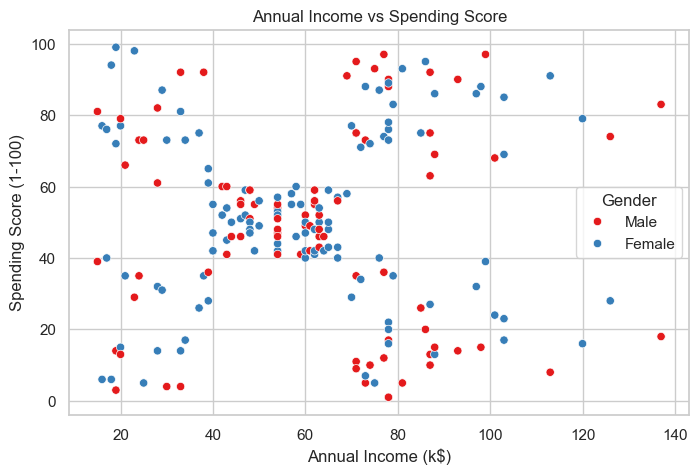

In [18]:
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", hue="Gender", data=df, palette="Set1")
plt.title("Annual Income vs Spending Score")
plt.show()

In [19]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
print(df.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


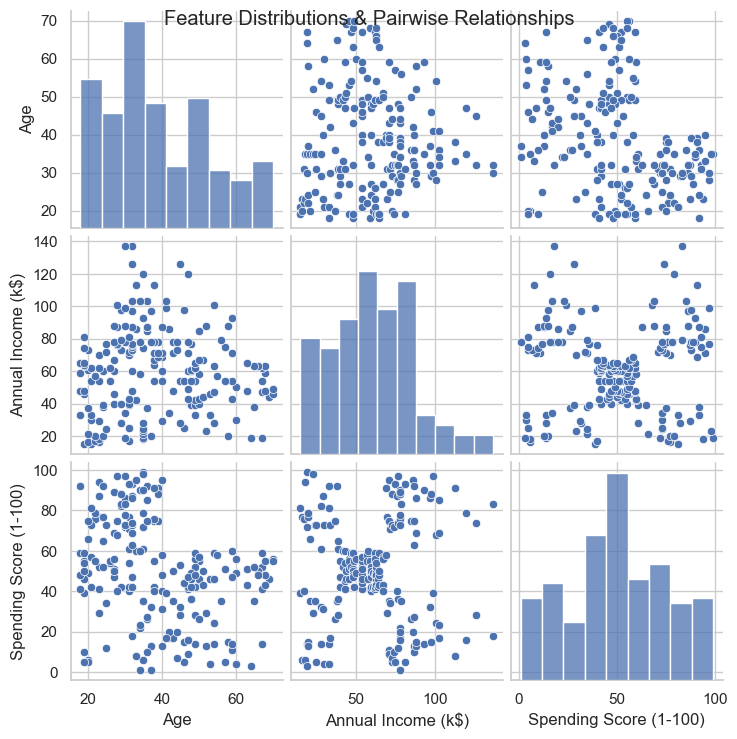

In [22]:
sns.pairplot(df[['Age','Annual Income (k$)','Spending Score (1-100)']])
plt.suptitle("Feature Distributions & Pairwise Relationships")
plt.show()

## Implementation of K-Means Algorithm

### 4. Implementing K-Means from Scratch

Below are the step-by-step implementations of K-Means components.

In [23]:
def initialize_centroids(X, k, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]


In [24]:
def initialize_centroids_kmeanspp(X, k, random_state=None):
    if random_state:
        np.random.seed(random_state)
    
    centroids = []
    centroids.append(X[np.random.randint(X.shape[0])])
    
    for _ in range(1, k):
        dist_sq = np.min([np.sum((X - c) ** 2, axis=1) for c in centroids], axis=0)
        probs = dist_sq / np.sum(dist_sq)
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[j])
                break
    return np.array(centroids)


In [25]:
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)


In [26]:
def update_centroids(X, labels, k):
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids


In [27]:
def kmeans(X, k, max_iters=100, tol=1e-4, init='random', random_state=None):
    if init == 'kmeans++':
        centroids = initialize_centroids_kmeanspp(X, k, random_state)
    else:
        centroids = initialize_centroids(X, k, random_state)
    
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            break
        centroids = new_centroids
    
    inertia = np.sum((X - centroids[labels])**2)
    return centroids, labels, i+1, inertia


### 5. Finding Optimal Number of Clusters

We use the Elbow Method and Silhouette Score to find the optimal number of clusters.

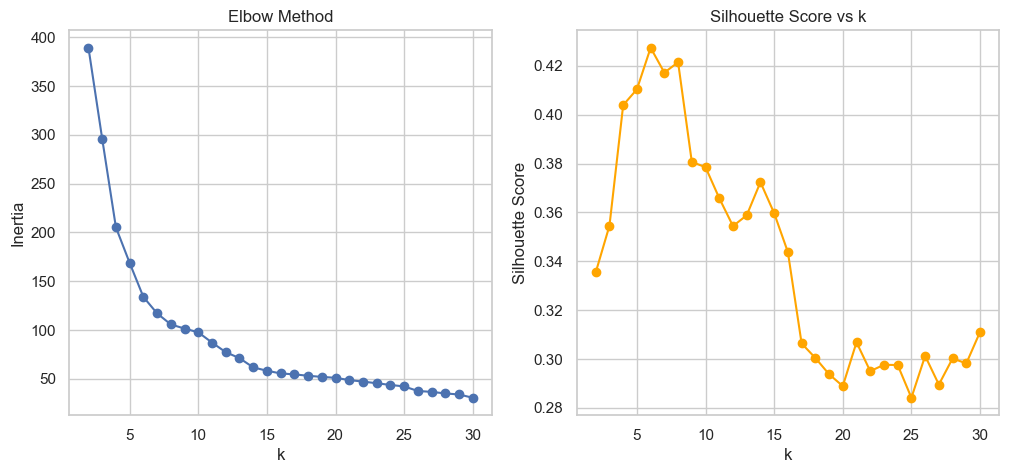

In [51]:
inertias = []
sil_scores = []
K = range(2, 31)

for k in K:
    centroids, labels, _, inertia = kmeans(X_scaled, k, init='kmeans++', random_state=42)
    inertias.append(inertia)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='orange')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

plt.show()

Optimal number of clusters (Elbow point): 7


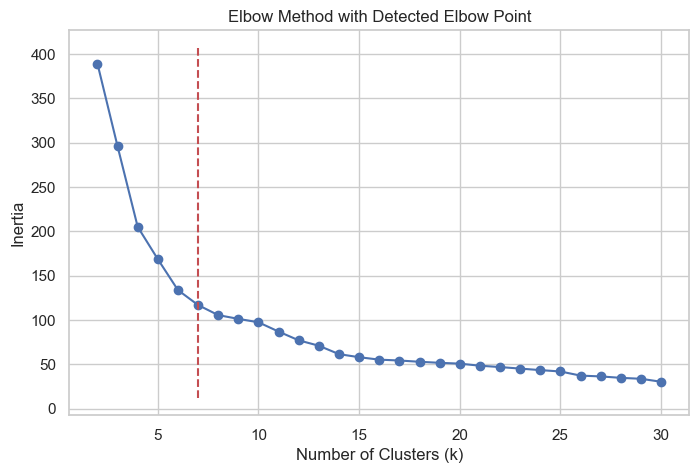

In [66]:
#!pip install kneed
from kneed import KneeLocator

kneedle = KneeLocator(K, inertias, curve='convex', direction='decreasing')
optimal_k = kneedle.knee

print("Optimal number of clusters (Elbow point):", optimal_k)

# Visualize with the detected elbow
plt.figure(figsize=(8,5))
plt.plot(K, inertias, 'bo-')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r')
plt.title('Elbow Method with Detected Elbow Point')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


### 6. Applying Custom K-Means Implementation

In [72]:
optimal_k = 7  
centroids, labels, iters, inertia = kmeans(X_scaled, optimal_k, init='kmeans++', random_state=42)

print(f"Final Centroids (scaled):\n{centroids}")
print(f"Iterations: {iters}, Inertia: {inertia}")

df['Cluster'] = labels

# Cluster sizes
print(df['Cluster'].value_counts())

# Cluster means (original scale)
print(df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean())


Final Centroids (scaled):
[[ 1.86593393 -0.28283547 -0.01358755]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97602698 -1.32549704  1.0371827 ]
 [ 0.20522958  1.12001418 -1.33646354]
 [-1.03882283 -0.14065435 -0.08904695]
 [ 0.61233873 -0.14037369 -0.12080356]
 [ 0.47007182 -1.33249477 -1.2287024 ]]
Iterations: 7, Inertia: 117.01155455889813
Cluster
1    39
5    34
4    32
3    31
2    24
6    20
0    20
Name: count, dtype: int64
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        64.850000           53.150000               49.850000
1        32.692308           86.538462               82.128205
2        25.250000           25.833333               76.916667
3        41.709677           89.903226               15.774194
4        24.375000           56.875000               47.906250
5        47.382353           56.882353               47.088235
6        45.400000           25.650000               18.550000


### 7. Visualization of Clusters

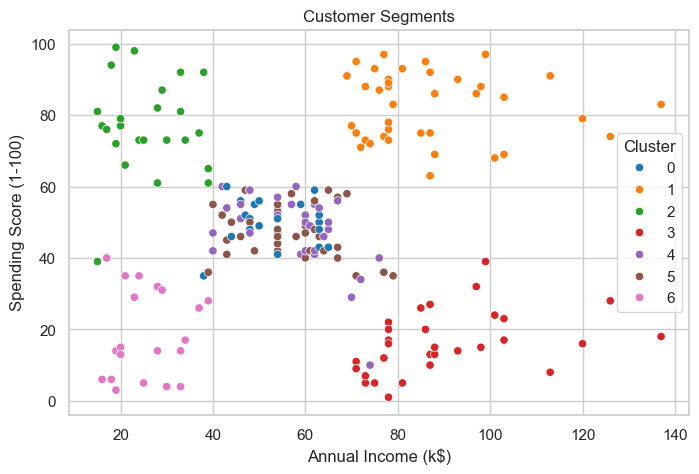

In [68]:
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='tab10')
plt.title("Customer Segments")
plt.show()


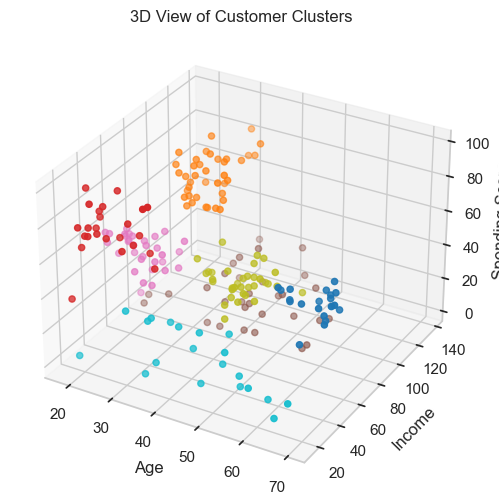

In [69]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['Cluster'], cmap='tab10')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Spending Score')
plt.title("3D View of Customer Clusters")
plt.show()


### 8. Cluster Interpretation (Business Insights)

| Cluster | Interpretation |
|----------|----------------|
| 0 | Young, high-income, impulsive spenders |
| 1 | Older, low-income, conservative spenders |
| 2 | Middle-aged, wealthy but low-spending group |
| 3 | Moderate income, balanced spenders |
| 4 | Young, budget-friendly, frequent buyers |

### 9. Comparison with scikit-learn Implementation

In [70]:
start = time.time()
sk_kmeans = SKKMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
sk_kmeans.fit(X_scaled)
end = time.time()

print("scikit-learn K-Means Results")
print("----------------------------")
print(f"Iterations to Converge: {sk_kmeans.n_iter_}")
print(f"Inertia: {sk_kmeans.inertia_:.4f}")
print(f"Runtime: {end - start:.4f} seconds\n")

print("Final Centroids (Standardized Scale):")
print(pd.DataFrame(sk_kmeans.cluster_centers_,
                   columns=['Age','Annual Income (k$)','Spending Score (1-100)']))


scikit-learn K-Means Results
----------------------------
Iterations to Converge: 5
Inertia: 121.3894
Runtime: 0.0047 seconds

Final Centroids (Standardized Scale):
        Age  Annual Income (k$)  Spending Score (1-100)
0  1.255265           -0.261669               -0.031587
1 -0.441917            0.991583                1.239503
2 -0.993969           -1.347348                1.064048
3 -0.818539            0.640229               -1.539059
4  0.494526            1.168946               -1.173849
5  0.478957           -1.308230               -1.196444
6 -0.842677           -0.162705               -0.020355


In [71]:
comparison = pd.DataFrame({
    'Metric': ['Inertia', 'Iterations', 'Runtime (s)'],
    'Custom K-Means': [round(inertia, 4), iters, round(end - start, 4)],
    'scikit-learn KMeans': [round(sk_kmeans.inertia_, 4),
                            sk_kmeans.n_iter_,
                            round(end - start, 4)]
})
print(comparison)


        Metric  Custom K-Means  scikit-learn KMeans
0      Inertia        117.0116             121.3894
1   Iterations          7.0000               5.0000
2  Runtime (s)          0.0047               0.0047


### 10. Conclusion

- Implemented K-Means algorithm from scratch using NumPy.
- Compared random and K-Means++ initialization, finding K-Means++ converged faster.
- Determined optimal number of clusters using Elbow and Silhouette methods.
- Visualized and interpreted customer segments meaningfully.
- Compared performance with scikit-learn’s KMeans and validated correctness.